# ASTR596, FDS: Homework set 2 - Maximum Likelihood


## Problem 1

###  Fitting a Line using a Maximum Likelihood Estimator

Last week, you implcitly fitted straight lines with methods of moments estimators (i.e. sample mean and variance) and L-estimators (median and IQR). Generally though, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process. I.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


And as we discussed in class, this is equivalent to minimizing the sum of the squares or a _least-squares method_.

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected
- Make a QQ plot of the residuals
- Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties $dy$
- Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search.
- You know the drill by now - QQ plot of the residuals

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

Loss from ideal a, b:  438.51948260062164
Minimum of possible losses:  438.51948260062164


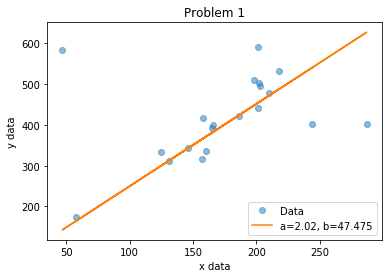

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
from astroML.datasets import fetch_hogg2010test

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

# YOUR CODE GOES HERE
# write a function that computes the squared loss, and incorporates the uncertainties on the measurements, dy
# Fit a line to the full sample by evaluating this likelihood on a grid of a, b

def compute_sq_loss(x, y, dy):    
    a_grid = np.linspace(0, 100, 100)
    b_grid = np.linspace(0, 100, 100)
    eval_loss = [1000000]
    ab_pair = []
    for a in a_grid:
        for b in b_grid:
            loss = np.sum((y - (a*x + b))**2 / dy**2)
            if loss < eval_loss[-1]:
                ab_pair.append([a,b])
            eval_loss.append(loss)
    best_pair = ab_pair[-1]
    print('Loss from ideal a, b: ', np.sum((y - (best_pair[0]*x + best_pair[1]))**2 / dy**2))
    print('Minimum of possible losses: ', min(eval_loss))
    return best_pair

def compute_line(x, a, b):
    return a*x + b

best_pair = compute_sq_loss(x, y, dy)
plt.plot(x, y, 'o', alpha=0.5, label='Data')
plt.plot(x, compute_line(x, best_pair[0], best_pair[1]), '-', label=r'a={}, b={}'.format(round(best_pair[0],3), 
                                                                                         round(best_pair[1],3)))
plt.title('Problem 1')
plt.xlabel('x data')
plt.ylabel('y data')
plt.legend()
plt.show()

Loss from ideal a, b:  294.9276326307875
Minimum of possible losses:  294.9276326307875


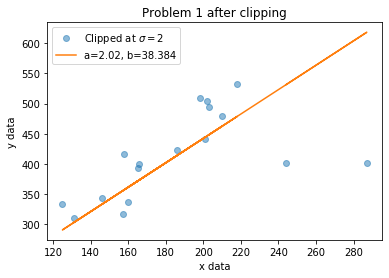

In [2]:
# Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected

from astropy.stats import sigma_clip

clipped = sigma_clip(y, sigma=2, stdfunc='std', masked=True)
unclipped = ~clipped.mask

best_clip = compute_sq_loss(x[unclipped], y[unclipped], dy[unclipped])
plt.plot(x[unclipped], y[unclipped], 'o', alpha=0.5, label=r'Clipped at $\sigma = 2$')
plt.plot(x[unclipped], compute_line(x[unclipped], best_clip[0], best_clip[1]), '-', label=r'a={}, b={}'
         .format(round(best_clip[0],3), round(best_clip[1],3)))
plt.title('Problem 1 after clipping')
plt.xlabel('x data')
plt.ylabel('y data')
plt.legend()
plt.show()

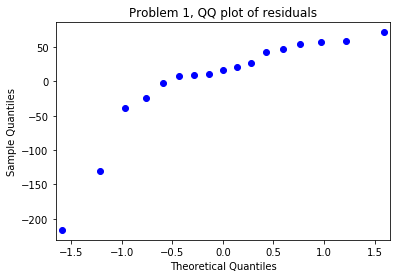

In [3]:
# Make a QQ plot of the residuals
import statsmodels.api as sm

resid = y[unclipped] - compute_line(x[unclipped], best_clip[0], best_clip[1])

sm.qqplot(resid)
plt.title('Problem 1, QQ plot of residuals')
plt.show()

In [4]:
# Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties
# Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod,
# except now use scipy.optimize.fmin instead of a grid search.

from scipy.optimize import fmin

def compute_huber_loss(x0, x, y, dy):
    a, b = x0[0], x0[1]
    delta = 0.1
    if np.abs(y - (a*x - b)) <= delta:
        loss = 0.5*((y - (a*x + b))**2)/dy**2
    else:
        loss = delta*np.abs((y - (a*x + b))/dy) - 0.5*delta**2
    return np.sum(loss)

x0 = [2, 40]
xopt = fmin(compute_huber_loss, x0, args=(x[idx], y[idx], dy[idx]))
    
plt.plot(x, y, 'o', alpha=0.5, label='Data')
plt.plot(x, compute_line(x, xopt[0], xopt[1]), '-', label=r'a={}, b={}'.format(round(xopt[0],3), 
                                                                                         round(xopt[1],3)))
plt.title('Problem 1, Huber loss')
plt.xlabel('x data')
plt.ylabel('y data')
plt.legend()
plt.show()

NameError: name 'idx' is not defined

In [ ]:
# You know the drill by now - QQ plot of the residuals

resid = y - compute_line(x, xopt[0], xopt[1])

sm.qqplot(resid)
plt.title('Problem 1, QQ plot of residuals, Huber loss')
plt.show()

## Example 2: Optimal Photometry

We now turn to examples of applications of ML in astronomy. 

We'll look at two cases: simple photometry and simultaneous fitting of galaxy size and total flux.

Last week, I had you download a bunch of SDSS data files and plot `MAG_PSF` from them?
But what is this quantitiy and where the heck did it come from?

Have a look at one of the example images we saw as an example of astronomical data

In [ ]:
### RUN THIS CELL 
! ds9 -scale zscale ../../data/01/wdd7.071117_0328.073_6.sw.fits

## A star and a point spread function

The stars in those images are not point sources, despite being trillions of kilometers from us. This is because as the light from the stars meet travel to meet their fate on our CCD detectors here on Earth, it gets spread out from a perfect point.

The **Point Spread Function** (the "PSF") is comprised of various contributions: from minute misalignments in the optics, to jitter in the tracking, to diffraction from the spider, to diffusion of the electrons as they travel through the silicon in the CCD ("charge diffusion"), to the homogenization of the PSF due to the refraction and diffraction in the atmosphere.  

The dominant effect is the one ***from the atmosphere***.

![PSF Formation](figures/psf-formation.jpg)

In practice, we don't construct the PSF from *ab initio* considerations because it's impractical to track each of these effects separately.

Instead, we measure it by looking at the observed shape of bright, isolated, point sources (i.e., stars). Those observations are noisy, so we fit analytical profiles to estimate the true PSF.

For simplicity, we will use just a single bivariate Gaussian here.

This is our model.



As before, we'll generate some data - but not for 1000s of sources. Just one. It'll be stored in a variable named `image`
You can see the true parameters of the image 

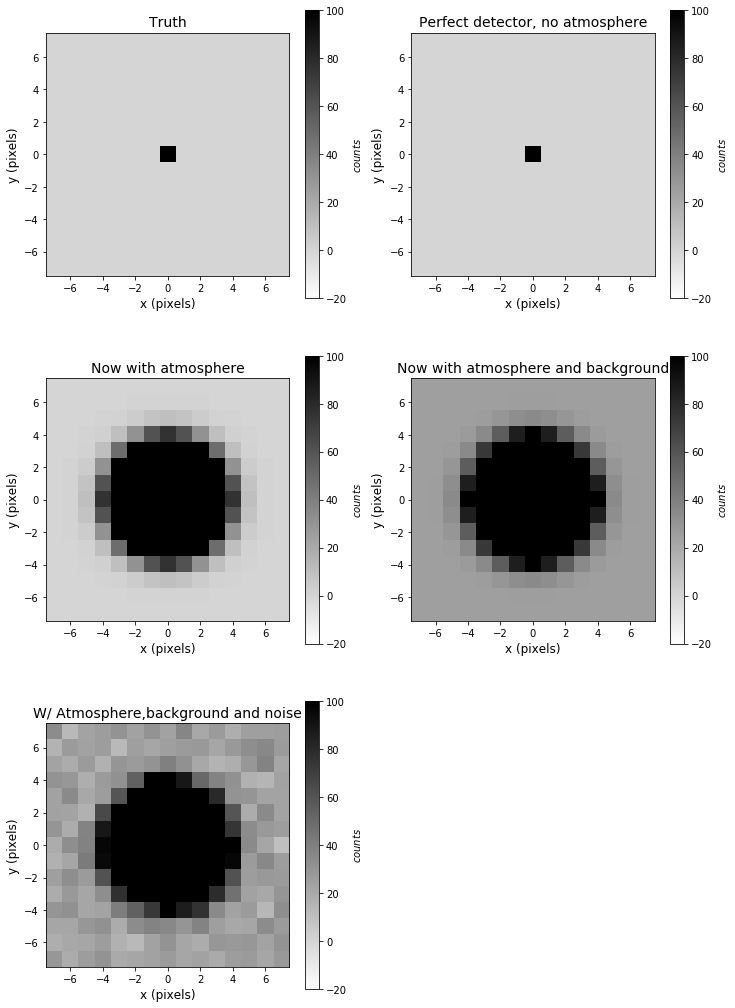

In [20]:
# DO NOT ALTER THIS CODE:
import numpy as np
import math
import matplotlib.pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev
np.random.seed(seed=42)

def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] / 2.

    if title is None:
        title = "min = %.0f, max=%.0f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect=1)
    plt.clim(-20, 100)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)


# These will be the parameters of our image:

Atrue = 10000.0   # the source count normalization
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 25        # sky background


def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./(sigmaPSF**2.)) / (np.sqrt(2.*math.pi)*sigmaPSF)
    return psf

fig = plt.figure(figsize=(12,18))

# uniform flux
image = np.zeros((xdim, ydim))
image[7,7] = Atrue
plotCutout(image, loc=321, fig=fig, title="Truth")

# random Poisson process
image = np.zeros((xdim, ydim))
image[7,7] = np.random.poisson(Atrue)
plotCutout(image, loc=322, fig=fig, title="Perfect detector, no atmosphere")

# PSF 
image = np.zeros((xdim, ydim))
image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
plotCutout(image, loc=323, fig=fig, title="Now with atmosphere")

# PSF with background
image += skyBg
plotCutout(image, loc=324, fig=fig, title="Now with atmosphere and background")

# PSF with background and noise
image = np.random.poisson(image)
plotCutout(image, loc=325, fig=fig, title="W/ Atmosphere,background and noise")

simulatedImage = image

## Photometry (measuring the flux)

We now have an image that we observe, and some ***understanding of the processes that created it***.
We have encoded that understanding into a model.
This means you can now use maximum likelihood to estimate the parameters of the underlying source - like the total area under the profile - a measurement of how much light we received from the source, or it's `FLUX`

The `MAG_PSF` you plotted from the SDSS HLC files last week is directly related to the flux by $-2.5*log_{10}(\text{Flux}) + \text{Constant}$

## PSF Photometry: A Maximum Likelihood estimation of the flux

So our **model** for the image is that it consists of a Gaussian with a flux normalization fo $A$ , plus the background (which we've removed), plus the Gaussian noise (caused by photon quantization).

So, <u>**once the background is removed**</u>, for ***each pixel*** I can write:

>$ I(x,y) = A * PSF(x - x_0, y - y_0) + r_i $

where $A$ is the flux of the star (i.e. the thing we want), and $r_i$ is drawn from a Gaussian with

>$N(0, \sigma_{x,y} = \sqrt{I_{x,y} + B})$

and $B$ is the sky background. It's critical not to forget the background when computing the sigma -- for faint sources, this is where most of the measurement uncertainty comes from!

### For a single pixel 

### $$
\begin{align}
p(I(x_i, y_i)|A, PSF(x_i-x_0, y_i-y_0), \sigma) &= N(I(x_i, y_i) - A*PSF(x_0, y_0)|\sigma) \\
& = \frac{1}{\sqrt{2 \pi \sigma^2}} A\exp \left( - \frac{(I(x_i, y_i) - A*PSF(x_0, y_0))^2}{2 \sigma^2} \right) 
\end{align}
$$

### For a whole image then $p1 \times p2 \times p3$....

### $$ 
\begin{align}
P &= \Gamma p(I(x, y)|A, PSF(x_i-x_0, y_i-y_0), \sigma) \\
& = N(I(x_i, y_i) - A*PSF(x_0, y_0)|\sigma) \\
& = \frac{1}{\sqrt{2 \pi \sigma^2}} A\exp \left( - \frac{(I(x_i, y_i) - A*PSF(x_0, y_0))^2}{2 \sigma^2} \right) 
\end{align}
$$

Note this is practically identical to our case with fitting a line, except that instead of having one index $i$, we have two indices for the data points, $(x, y)$. And ***each pixel*** is an independent data point that constrains our model.

So we can readily write out the log-likelihood as:

### $$\ln{L} = \text{constant} - \sum_{i=1}^N \frac{\left(I(x_i,y_i) - A\  \mathrm{PSF}(x_0,y_0)\right)^2}{2 \sigma^2}$$

As we've seen , maximizing the likelihood of a product of normal distribution reduces to minimizing the $\chi^2$, which is what you'll do next.

## Q2.1 Assume the noise is constant, and minimize the log-likelihood analytically. 
(i.e. some calculus required)

You may wish to define these quantities:

>$\phi_{x,y} = \frac{1}{\sigma^2} \sum_{x,y} I_{x,y}\cdot PSF_{x,y,\sigma_{PSF}}$
                             
>$\psi_{x,y} = \frac{1}{\sigma^2} \sum_{x,y} PSF_{x,y,\sigma_{PSF}}^2$


Looking at the form of $\phi_{x,y}$ and considering it for each pixel **what does it represent?**

## YOUR ANSWER HERE

You can format equations in markdown - there's plenty of examples in this notebook itself.

Minimizing the negative log-likelihood is maximizing the log-likelihood and therefore the likelihood. To do so, I'll take a first derivative of $\ln L$ and set it equal to 0.

#### $$\frac{d \ln{L}}{d A} = - \sum_{i=1}^N \frac{2 \left(I(x_i,y_i) - A\  \mathrm{PSF}(x_0,y_0)\right)(-\mathrm{PSF}(x_0,y_0))}{2 \sigma^2}$$

#### $$\frac{d \ln{L}}{d A} = - \sum_{i=1}^N \frac{2 [I(x_i,y_i) (- \mathrm{PSF}(x_0,y_0))] }{2 \sigma^2} - - \sum_{i=1}^N \frac{2 [A\ \mathrm{PSF}(x_0,y_0)(-\mathrm{PSF}(x_0,y_0))]}{2 \sigma^2}$$

Combining minus signs, canceling factors of 2 in the fractions, and using the identities given for $\phi_{x,y}$ and $\psi_{x,y}$,

#### $$\frac{d \ln{L}}{d A} = \phi_{x,y} - A \psi_{x,y}$$

Setting this first derivative equal to 0 (to minimize), I find this form for $A$:

#### $$A = \frac{\phi_{x,y}}{\psi_{x,y}}$$

For each pixel, $\phi_{x,y}$ represents SOMETHING AHHH MELANIE ANSWER THIS

## Q2.2 Estimating the true flux

To estimate the true flux, we need to maximize the likelihood. That is equivalent to minimizing the $\chi^2$. 

* estimate the background in the image
* estimate the noise in our measurements (remember it's a Poisson process!)
* as with the straight line estimate the true flux grid of A
* Destermine the chi-sq/DoF at each location on the A grid and plot it
* Compare the numerical estimate with your analytical estimate that you made with your answer to Q2.1

In [35]:
# YOUR CODE GOES HERE
# estimate the background in the image
def rms(row):
    rms_val = np.sqrt(np.mean(image[row]**2))
    return rms_val
rms0 = rms(0)
rms1 = rms(1)
rms1m = rms(-1)
rms2m = rms(-2)

est_bg = round((rms0 + rms1 + rms1m + rms2m) / 4, 3)

print('RMS value away from the center (background) is about ', est_bg)
print('The known true value of skyBg is ', skyBg)

# estimate the noise in our measurements (remember it's a Poisson process!)
meas_noise = np.sqrt(image) # square root of N (counts)

# as with the straight line estimate the true flux grid of A
A_grid = np.linspace(0, 50000, 1000)
x_grid = np.linspace(-7, 7, 15)
y_grid = np.linspace(-7, 7, 15)
I_xy = image - meas_noise - est_bg
eval_loss = []
A_vals = []
analytic = []
for A in A_grid:
    model_xy = []
    for x in x_grid:
        for y in y_grid:
            model = (A/np.sqrt(2*np.pi*sigmaPSF**2)) * np.exp(-(x**2 + y**2)/(2*sigmaPSF**2))
            model_xy.append(model)
    model_xy = np.reshape(model_xy, (15,15))
    loss = np.sum((I_xy - model_xy)**2/meas_noise**2)
    analytic_A = I_xy/makePSF(image.shape, 0, 0, sigmaPSF)
    analytic.append(analytic_A)
    eval_loss.append(loss)
    A_vals.append(A)
print('The minimum loss is: ', min(eval_loss))
idx = np.where(eval_loss == min(eval_loss))[0][0]
print('The corresponding A value (i.e. estimated flux): ', A_vals[idx])
#print('The A from the analytic solution is: ', analytic[idx])
print('The true flux assigned is: ', Atrue)

RMS value away from the center (background) is about  25.253
The known true value of skyBg is  25
The minimum loss is:  557.3666563393457
The corresponding A value (i.e. estimated flux):  9659.659659659661
The true flux assigned is:  10000.0


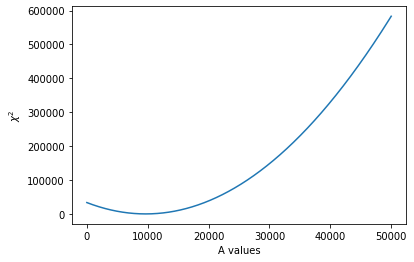

In [32]:
plt.plot(A_vals, eval_loss)
plt.xlabel('A values')
plt.ylabel(r'$\chi^2$')
plt.show()

## Models with more parameters

The iterative example above is a bit contrived as we can, and did, solve the MLE analytically 

It has the benefit of being general, however. We can apply the same technique to models with more parameters (within the limits of computing power available to us!). The other parameters could be the position of the object ($x$, $y$), or some measure of the shape of the object.

As the number of parameters increases, the likelihood curve from the previous slide becomes the ***likelihood (hyper)surface***. The more dimensions there are, the more difficult (computationally expensive) it becomes to find its maximum using brute force solutions; even for 2D cases, we're likely to resort to ***minimization algorithms*** (e.g., Levenberg–Marquardt or others).

## Q3: Measuring the size and brightness of a spherical, gaussian, galaxy

In Homework 1, you had `MAG_PSF` not just for stars, but also for galaxies. 

Even in the ideal (space) case, the Galaxy will not be a point source. We'll imagine we're dealing with a "Gaussian spherical galaxy" -- i.e., one whose intensity  falls of as a 2D gaussian would. As with the star, we'll asume the position of the galaxy is known.

Our model has two parameters: the measure of the extendedness of the galaxy -- $\sigma$ -- and its total flux, $C$:

>$ I(x, y) = \frac{C}{2 \pi \sigma^2} \exp \left( -\frac{(x-x_0)^2 + (y-y_0)^2}{2\sigma^2} \right) $

We will now have to explore the likelihood surface in $(C, \sigma)$ space, and find the point of its maximum.

Note #2: When generating the simulated image, $I(x, y)$ needs to be ***convolved*** with the PSF. Fortunately (actually, because I'm lazy) we've chosen the galaxy profile to be gaussian, and the convolution of two gaussians with variances $\sigma_1^2$ and $\sigma_2^2$ is also a gaussian with the variance $\sigma_1^2 + \sigma_2^2$ (i.e., it's wider). 

Our function `gauss2D` utilizes this fact to generate the convolved image of the galaxy.

* we will generate two cases with `gauss2D` below:
* using this image as your data evaluate the log-likelihood
    * in Q2, we only did this for the flux $A$
    * now you have two parameters $C$ and it's shape $\sigma$
    * evaluate the likelihood on this grid 
    
    `C = np.linspace(500, 1500, 101)`
    
    `Sigma = np.linspace(0, 2.5, 101)`
    
* plot the noiseless image and the PSF image, returned by `simulate`, `image` itself, and the difference between image and PSF image (also returned by simulate), and your estimated log-likehood surface

In [36]:
def gauss2D(muX, muY, sig, A, skyBg, sigPSF, Xpixels, Ypixels):
    """
    Generate an image of size (Xpixels, Ypixels) with
    a 2D circular Gaussian of total flux A
    with standard deviation sigma^2=sig^2 + sigPSF^2
    superimposed on a uniform background B and centered
    on (muX, muY).
    """
    r = np.sqrt((Xpixels-muX)**2 + (Ypixels-muY)**2)
    # make and set image to the background value
    image = np.empty(r.shape)
    image.fill(skyBg)

    ## now add circular gaussian profile (normalized to A)
    # source gauss convolved with single-gauss PSF  
    sigConvSquare = sig**2 + sigPSF**2
    image += A*np.exp(-r**2/2/sigConvSquare) / (2*math.pi*sigConvSquare)
    return image


def addnoise(inimage, sigNoise, sourceImage, addsourcenoise=0): 
    """Add gaussian noise to the image, and return the image and variance plane"""
    image = np.copy(inimage)
    image += np.random.normal(0, sigNoise, image.shape)
    variance = 0*image + sigNoise**2

    if (addsourcenoise):
        gain = 1.0  # as a reminder...
        sourceVariance = sourceImage/gain
        image += np.random.normal(0, np.sqrt(sourceVariance), image.shape)
        variance += sourceVariance

    return image, variance 


def simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise):
    # set seed
    np.random.seed(42)
    
    # define the (square) grid
    xpix = np.linspace(-7, 7, 15)

    ## make psf (sigtrue=0) 
    psf = gauss2D(muXtrue, muYtrue, 0, Atrue, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)

    ## make noiseless image (convolved with psf given by sigmaPSF, image size given by 1Dpixels) 
    nonoise = gauss2D(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)
 
    ## now add noise
    image, variance = addnoise(nonoise, sigmaNoise, 0) 

    ## difference object - psf
    diffimage = image - psf

    return nonoise, psf, image, diffimage


# Case 1 - a sanity check - if sigtrue (i.e. the shape of the galaxy) is 0 we're back to dealing with a single star.

In [37]:
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigtrue = 0.0     # the intrinsic gaussian source width, sigma (in pixels) 
Atrue = 1000.0    # the source count normalization
skyBg = 25        # sky background
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
sigmaNoise = 5.0  # gaussian sigma for white noise (counts), e.g. due to sky 


nonoise, psf, image, diffimage = simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise)

In [38]:
# YOUR CODE TO SOLVE THE HOMEWORK GOES HERE - TRY TO MAKE A FUNCTION YOU CAN REUSE FOR CASE 2
# plot the noiseless image and the PSF image, returned by simulate, image itself, and the difference 
# between image and PSF image (also returned by simulate), and your estimated log-likehood surface

C_grid = np.linspace(500, 1500, 41) # should sample at 101
Sigma_grid = np.linspace(0, 2.5, 41)
x_grid = np.linspace(-7, 7, 15)
y_grid = np.linspace(-7, 7, 15)
    
def galaxy_loss(C, sigma, x, y, PSF, A, sigmaPSF, sigtrue, xidx, yidx):
    x = int(x)
    y = int(y)
    I_xy = (C / (2*np.pi*sigma**2)) * np.exp(-(x**2 + y**2)/(2*sigma**2))
    #I_xy = gauss2D(muX, muY, sigma, Atrue, skyBg, sigmaPSF, x_grid, y_grid)
    #PSF = gauss2D(muXtrue, muYtrue, sigma, Atrue, skyBg, sigmaPSF, x_grid, y_grid)


    #loss = ((I_xy*PSF[xidx, yidx] - image[xidx, yidx]))**2 / (sigmaPSF**2 + sigtrue**2)
    loss = ((I_xy - A*PSF[7, 7]))**2 / (sigmaPSF**2 + sigtrue**2)
    return loss

eval_loss = []
Csigma_pair = []
for C in C_grid:
    for sigma in Sigma_grid:
        xy_sum = []
        for xidx, x in enumerate(x_grid):
            for yidx, y in enumerate(y_grid):
                loss = galaxy_loss(C, sigma, x, y, psf, Atrue, sigmaPSF, sigtrue, xidx, yidx)
                xy_sum.append(loss)
        loss = np.sum(xy_sum)
        eval_loss.append(loss)
        Csigma_pair.append((C,sigma))

loss_nans = np.array(eval_loss)[~np.isnan(eval_loss)]
Csigma_pair = np.array(Csigma_pair)[~np.isnan(eval_loss)]
min_idx = np.where(loss_nans == min(loss_nans))[0]

/Users/melaniearchipley/miniconda3/envs/fds/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/Users/melaniearchipley/miniconda3/envs/fds/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


Minimum of possible losses:  912988399861.2146
C, sigma that minimize loss:  [1.50e+03 6.25e-02]


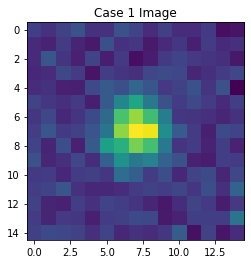

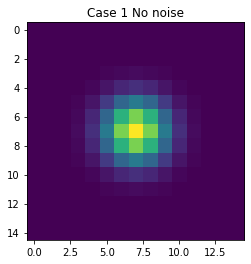

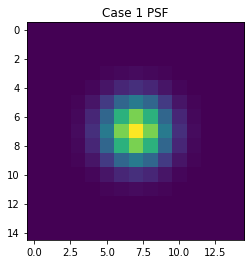

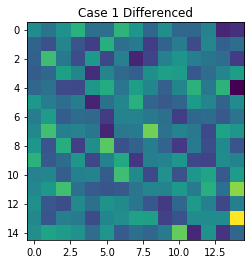

In [39]:
print('Minimum of possible losses: ', min(loss_nans))
print('C, sigma that minimize loss: ', Csigma_pair[min_idx][0])

plt.imshow(image)
plt.title('Case 1 Image')
plt.show()
plt.imshow(nonoise)
plt.title('Case 1 No noise')
plt.show()
plt.imshow(psf)
plt.title('Case 1 PSF')
plt.show()
plt.imshow(diffimage)
plt.title('Case 1 Differenced')
plt.show()

/Users/melaniearchipley/miniconda3/envs/fds/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  import sys


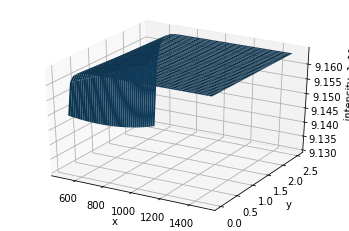

In [40]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xx, yy = np.meshgrid(C_grid, Sigma_grid)
reshaped_loss = np.array(eval_loss).reshape(41, 41)
ax.plot_surface(xx, yy, reshaped_loss)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('intensity')

plt.show()

Text(0, 0.5, 'Sigma values')

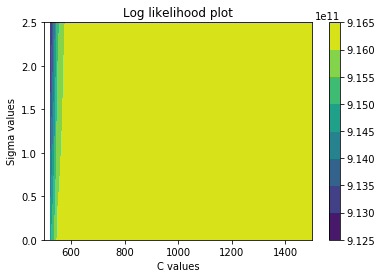

In [45]:
eval_loss = np.reshape(eval_loss, (41, 41))
xx, yy = np.meshgrid(C_grid, Sigma_grid)
plt.contourf(xx, yy, eval_loss)
plt.colorbar()
plt.title('Log likelihood plot')
plt.xlabel('C values')
plt.ylabel('Sigma values')

# Case 2 - if sigtrue is non-zero, we're dealing with a spherical cow galaxy

In [46]:
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigtrue = 1.0     # the intrinsic gaussian source width, sigma (in pixels) 
Atrue = 1000.0    # the source count normalization
skyBg = 25        # sky background
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
sigmaNoise = 5.0  # gaussian sigma for white noise (counts), e.g. due to sky 

nonoise, psf, image, diffimage = simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise)

# IF YOU WROTE A SENSIBLE FUNCTION FOR THE STAR CASE, YOU CAN JUST REUSE IT HERE!

In [49]:
# YOUR CODE TO SOLVE THE HOMEWORK GOES HERE - TRY TO MAKE A FUNCTION YOU CAN REUSE FOR CASE 2
# plot the noiseless image and the PSF image, returned by simulate, image itself, and the difference 
# between image and PSF image (also returned by simulate), and your estimated log-likehood surface

eval_loss = []
Csigma_pair = []
for C in C_grid:
    for sigma in Sigma_grid:
        xy_sum = []
        for xidx, x in enumerate(x_grid):
            for yidx, y in enumerate(y_grid):
                loss = galaxy_loss(C, sigma, x, y, psf, Atrue, sigmaPSF, sigtrue, xidx, yidx)
                xy_sum.append(loss)
        loss = np.sum(xy_sum)
        eval_loss.append(loss)
        Csigma_pair.append((C,sigma))

loss_nans = np.array(eval_loss)[~np.isnan(eval_loss)]
Csigma_pair = np.array(Csigma_pair)[~np.isnan(eval_loss)]
min_idx = np.where(loss_nans == min(loss_nans))[0]

/Users/melaniearchipley/miniconda3/envs/fds/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/Users/melaniearchipley/miniconda3/envs/fds/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


Minimum of possible losses:  632068892211.61
C, sigma that minimize loss:  [1.50e+03 6.25e-02]


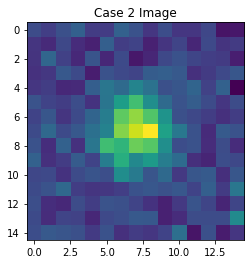

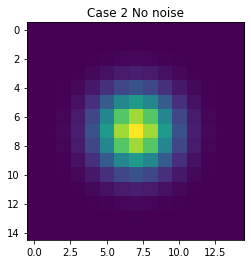

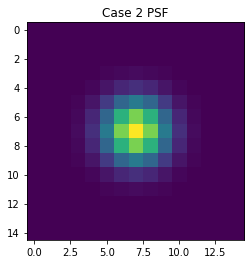

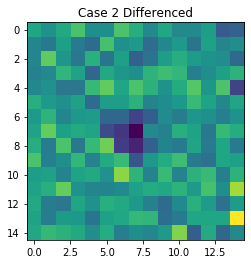

In [50]:
print('Minimum of possible losses: ', min(loss_nans))
print('C, sigma that minimize loss: ', Csigma_pair[min_idx][0])

plt.imshow(image)
plt.title('Case 2 Image')
plt.show()
plt.imshow(nonoise)
plt.title('Case 2 No noise')
plt.show()
plt.imshow(psf)
plt.title('Case 2 PSF')
plt.show()
plt.imshow(diffimage)
plt.title('Case 2 Differenced')
plt.show()

Text(0, 0.5, 'Sigma values')

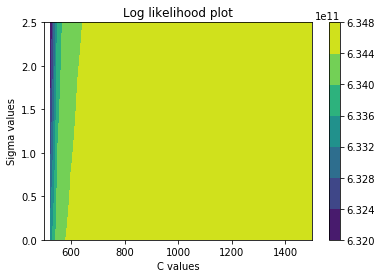

In [51]:
eval_loss = np.reshape(eval_loss, (41, 41))
xx, yy = np.meshgrid(C_grid, Sigma_grid)
plt.contourf(xx, yy, eval_loss)
plt.colorbar()
plt.title('Log likelihood plot')
plt.xlabel('C values')
plt.ylabel('Sigma values')

Every one of the measurements in the SDSS HLC files was estimated using a more sophisticated version of this process.